In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# import pandas as pd
# import os

# # Load the dataset
# file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/IDoFT_dataset.csv"
# data = pd.read_csv(file_path)

# # Extract the relevant fields: 'preprocessed_code' and 'category'
# relevant_data = data[['preprocessed_code', 'category']]

# # Filter out the categories to include only 0, 1, 2, 3, 4, and 5
# filtered_data = relevant_data[relevant_data['category'].isin([0, 1, 2, 3, 4, 5])]

# # Sample 50 points from each category
# sampled_data = filtered_data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

# # Print the sampled data
# print(sampled_data)

# # Process filenames and categories
# categories = {}

# # Assuming that the filenames are in a specific directory
# directory_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/"
# filenames = next(os.walk(directory_path), (None, None, []))[2]

# for file in filenames:
#     if "@" in file:
#         label = (file.split("@")[1]).split('.')[0].strip().lower()
#         if label not in categories.keys():
#             categories[label] = 0
#         categories[label] += 1

# print("\n==> All data : \n")
# for x, y in categories.items():
#     print(x, y)


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Load the dataset
file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/IDoFT_dataset.csv"
data = pd.read_csv(file_path)

# Extract the relevant fields: 'preprocessed_code' and 'category'
relevant_data = data[['preprocessed_code', 'category']]

# Filter out the categories to include only 0, 1, 2, 3, 4, and 5
filtered_data = relevant_data[relevant_data['category'].isin([0, 1, 2, 3, 4, 5])]

# Sample 50 points from each category
sampled_data = filtered_data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)

# Split the sampled data into training and validation sets
train_data, valid_data = train_test_split(sampled_data, test_size=0.2, random_state=42)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))

# Process filenames and categories
categories = {}

# Assuming that the filenames are in a specific directory
directory_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/"
filenames = next(os.walk(directory_path), (None, None, []))[2]

for file in filenames:
    if "@" in file:
        label = (file.split("@")[1]).split('.')[0].strip().lower()
        if label not in categories.keys():
            categories[label] = 0
        categories[label] += 1

print("\n==> All data : \n")
for x, y in categories.items():
    print(x, y)


Train buggy code: 240
Validation buggy code: 60
Train categories: 240
Validation categories: 60

==> All data : 



/tmp/ipykernel_1252067/442649916.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = filtered_data.groupby('category', group_keys=False).apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)


In [5]:
label_to_int= {
    'OD': 0,
    'NIO': 1,
    'ID': 2,
    'NDOD': 3,
    'NOD': 4,
    'UD':5
}

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, categories, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.max_len = 0
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 26880 - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, 26880 - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, 26880 - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 26880 - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts




In [7]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Train dataloader length: 30
Validation dataloader length: 8


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 240/240 [00:02<00:00, 106.03it/s]


In [10]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [11]:
max_length

26880

In [12]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


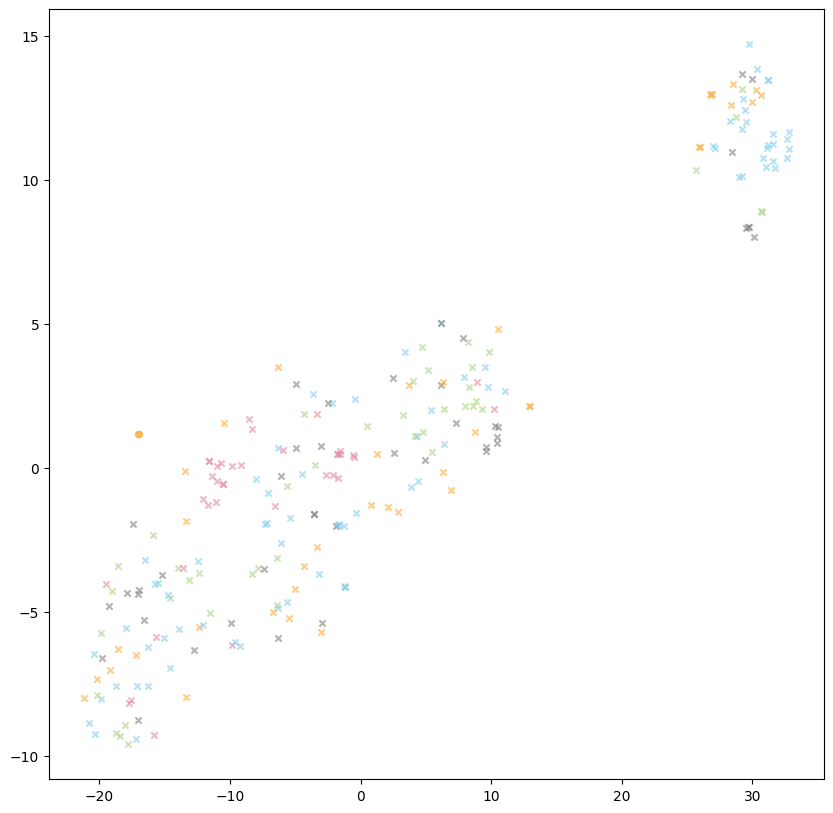

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [14]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [15]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [16]:
learning_rate = 1e-5
num_epochs = 200
embed_size = 26880  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [17]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [18]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 400
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'FlakyXbert_IDoFT_small_epoch400.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Epoch 1/400, Loss: 1.2596235533555349


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


Epoch 2/400, Loss: 1.012571531534195


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 3/400, Loss: 0.9964321792125702


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Epoch 4/400, Loss: 0.9601248443126679


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 5/400, Loss: 0.8866594821214676


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 6/400, Loss: 0.8940400004386901


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Epoch 7/400, Loss: 0.9582375844319662


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 8/400, Loss: 0.8289191792408626


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Epoch 9/400, Loss: 0.8758579870065053


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 10/400, Loss: 0.8365476826826731


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 11/400, Loss: 0.8566934923330943


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 12/400, Loss: 0.8501405527194341


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 13/400, Loss: 0.8769869108994802


100%|██████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch 14/400, Loss: 0.8811856309572855


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 15/400, Loss: 0.8624625424544017


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 16/400, Loss: 0.8412843614816665


100%|██████████| 30/30 [00:04<00:00,  6.29it/s]


Epoch 17/400, Loss: 0.8976830422878266


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 18/400, Loss: 0.8335910240809122


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 19/400, Loss: 0.819038846095403


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 20/400, Loss: 0.8031058073043823


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 21/400, Loss: 0.7979345937569936


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 22/400, Loss: 0.8199416021505992


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 23/400, Loss: 0.8050854206085205


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 24/400, Loss: 0.7832626114288966


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 25/400, Loss: 0.8060855825742086


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 26/400, Loss: 0.7262824892997741


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 27/400, Loss: 0.7049990236759186


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Epoch 28/400, Loss: 0.7805518716573715


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


Epoch 29/400, Loss: 0.7124848574399948


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 30/400, Loss: 0.7580977261066437


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 31/400, Loss: 0.7044644455115


100%|██████████| 30/30 [00:04<00:00,  6.78it/s]


Epoch 32/400, Loss: 0.6578205277522405


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 33/400, Loss: 0.6918000961343448


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 34/400, Loss: 0.6161421646674474


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 35/400, Loss: 0.6768082837263744


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 36/400, Loss: 0.6990745335817337


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 37/400, Loss: 0.6131743828455607


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Epoch 38/400, Loss: 0.6746519903341929


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 39/400, Loss: 0.6402605791886647


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 40/400, Loss: 0.5768323669830958


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 41/400, Loss: 0.6122647563616435


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 42/400, Loss: 0.5815199986100197


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 43/400, Loss: 0.5899481823047003


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 44/400, Loss: 0.5644175296028455


100%|██████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch 45/400, Loss: 0.6848599970340729


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 46/400, Loss: 0.6208125447233518


100%|██████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch 47/400, Loss: 0.6272379000981648


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 48/400, Loss: 0.5662395517031352


100%|██████████| 30/30 [00:04<00:00,  6.41it/s]


Epoch 49/400, Loss: 0.530782359590133


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 50/400, Loss: 0.5042349497477213


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


Epoch 51/400, Loss: 0.49877873361110686


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 52/400, Loss: 0.5326433196663857


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 53/400, Loss: 0.5204304640491804


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 54/400, Loss: 0.40686384290456773


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 55/400, Loss: 0.5109242682655653


100%|██████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch 56/400, Loss: 0.5631301780541738


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 57/400, Loss: 0.5177599390347799


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 58/400, Loss: 0.5183782244722048


100%|██████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch 59/400, Loss: 0.48819726357857385


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 60/400, Loss: 0.485113924741745


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 61/400, Loss: 0.49945418213804565


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


Epoch 62/400, Loss: 0.4633914257089297


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 63/400, Loss: 0.4775190159678459


100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch 64/400, Loss: 0.5854394103089968


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 65/400, Loss: 0.5430928505957127


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 66/400, Loss: 0.34008659794926643


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 67/400, Loss: 0.46037992611527445


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 68/400, Loss: 0.5490524833401044


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 69/400, Loss: 0.42912881126006447


100%|██████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch 70/400, Loss: 0.4447814665734768


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 71/400, Loss: 0.37756383245189984


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 72/400, Loss: 0.4064924518267314


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 73/400, Loss: 0.40087475727001826


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 74/400, Loss: 0.43822470158338545


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 75/400, Loss: 0.4289689098795255


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 76/400, Loss: 0.420195509493351


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 77/400, Loss: 0.3606089127560457


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 78/400, Loss: 0.40664330770572027


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 79/400, Loss: 0.4659472624460856


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 80/400, Loss: 0.45184324607253074


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 81/400, Loss: 0.41983229865630467


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 82/400, Loss: 0.32890399446090063


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 83/400, Loss: 0.3152645175655683


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 84/400, Loss: 0.37288754880428315


100%|██████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch 85/400, Loss: 0.33602480466167134


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 86/400, Loss: 0.3638174856702487


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 87/400, Loss: 0.32376106654604275


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 88/400, Loss: 0.41636170670390127


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 89/400, Loss: 0.3218922637403011


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 90/400, Loss: 0.34113503570357956


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Epoch 91/400, Loss: 0.30356208235025406


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 92/400, Loss: 0.35944246376554173


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 93/400, Loss: 0.27100829482078553


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 94/400, Loss: 0.3592669486999512


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 95/400, Loss: 0.2475774683058262


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 96/400, Loss: 0.3075850976010164


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 97/400, Loss: 0.28403142218788463


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 98/400, Loss: 0.3059032122294108


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 99/400, Loss: 0.2682616027692954


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 100/400, Loss: 0.26477053662141165


100%|██████████| 30/30 [00:04<00:00,  6.39it/s]


Epoch 101/400, Loss: 0.29206588566303254


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 102/400, Loss: 0.3458109157780806


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 103/400, Loss: 0.2708107178409894


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 104/400, Loss: 0.28467710241675376


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 105/400, Loss: 0.34160241931676866


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.88it/s]


Epoch 106/400, Loss: 0.24141857400536537


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 107/400, Loss: 0.3328754879534245


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 108/400, Loss: 0.3336237743496895


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 109/400, Loss: 0.25560590003927547


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 110/400, Loss: 0.2627306704719861


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 111/400, Loss: 0.2872843856612841


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 112/400, Loss: 0.30282672941684724


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 113/400, Loss: 0.28852507198850313


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 114/400, Loss: 0.2862542651593685


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 115/400, Loss: 0.21450086707870167


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:18,  2.72s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Epoch 116/400, Loss: 0.27179483075936633


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 117/400, Loss: 0.19537384857734044


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 118/400, Loss: 0.22942343826095263


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 119/400, Loss: 0.28731113523244856


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 120/400, Loss: 0.24453367615739505


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 121/400, Loss: 0.2807163275778294


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 122/400, Loss: 0.2209511563181877


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 123/400, Loss: 0.21910186285773914


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 124/400, Loss: 0.2593309293190638


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 125/400, Loss: 0.21986233418186504


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 126/400, Loss: 0.30926763514677685


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 127/400, Loss: 0.1836288203795751


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 128/400, Loss: 0.3133917048573494


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 129/400, Loss: 0.26279134427507717


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 130/400, Loss: 0.33464539274573324


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 131/400, Loss: 0.27773671398560207


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Epoch 132/400, Loss: 0.33990743284424146


100%|██████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch 133/400, Loss: 0.25660507728656134


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 134/400, Loss: 0.25897401322921115


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 135/400, Loss: 0.21893638893961906


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 136/400, Loss: 0.213754237194856


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 137/400, Loss: 0.21522203584512076


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.66s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Epoch 138/400, Loss: 0.23525166288018226


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 139/400, Loss: 0.21578779195745787


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Epoch 140/400, Loss: 0.2217677672704061


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 141/400, Loss: 0.20106406211853028


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 142/400, Loss: 0.18862391064564388


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 143/400, Loss: 0.20827291359504063


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.20it/s]


Epoch 144/400, Loss: 0.19843902389208476


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 145/400, Loss: 0.1874441049993038


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 146/400, Loss: 0.16473766167958578


100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


Epoch 147/400, Loss: 0.21084554344415665


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 148/400, Loss: 0.18140638023614883


100%|██████████| 30/30 [00:04<00:00,  6.79it/s]


Epoch 149/400, Loss: 0.2078196143110593


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Epoch 150/400, Loss: 0.1958516664803028


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 151/400, Loss: 0.22727033073703448


100%|██████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch 152/400, Loss: 0.3144455760717392


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 153/400, Loss: 0.19218989287813504


100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


Epoch 154/400, Loss: 0.15562153433760006


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Epoch 155/400, Loss: 0.1582604984442393


100%|██████████| 30/30 [00:04<00:00,  6.35it/s]


Epoch 156/400, Loss: 0.21550240392486256


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 157/400, Loss: 0.1912437029182911


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 158/400, Loss: 0.1988908718029658


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 159/400, Loss: 0.2407558371623357


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 160/400, Loss: 0.14227728868524234


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Epoch 161/400, Loss: 0.16408658102154733


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 162/400, Loss: 0.1285808021823565


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 163/400, Loss: 0.19067085882027943


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Epoch 164/400, Loss: 0.23736508091290792


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 165/400, Loss: 0.19626551841696102


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.20it/s]


Epoch 166/400, Loss: 0.18093829303979875


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 167/400, Loss: 0.12588449443380037


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Epoch 168/400, Loss: 0.16012439106901485


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


Epoch 169/400, Loss: 0.16214655662576358


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 170/400, Loss: 0.1099449078241984


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 171/400, Loss: 0.16696609010299046


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 172/400, Loss: 0.14918372159202895


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 173/400, Loss: 0.16258093218008676


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:18,  2.70s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 174/400, Loss: 0.15052039151390392


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 175/400, Loss: 0.16998956874012947


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Epoch 176/400, Loss: 0.16702565674980482


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 177/400, Loss: 0.24197068562110266


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 178/400, Loss: 0.1857460913558801


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 179/400, Loss: 0.1372419829169909


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


Epoch 180/400, Loss: 0.16027581046024958


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 181/400, Loss: 0.11358564520875612


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 182/400, Loss: 0.2254759778579076


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 183/400, Loss: 0.19989209895332655


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 184/400, Loss: 0.09755390534798304


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Epoch 185/400, Loss: 0.11917095979054769


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 186/400, Loss: 0.14818334206938744


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Epoch 187/400, Loss: 0.15914885525902112


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.66s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.06it/s]


Epoch 188/400, Loss: 0.1188628613948822


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Epoch 189/400, Loss: 0.18374593555927277


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 190/400, Loss: 0.1876420718928178


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.07it/s]


Epoch 191/400, Loss: 0.1526150144636631


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 192/400, Loss: 0.11288892899950345


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 193/400, Loss: 0.10346223513285319


100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch 194/400, Loss: 0.15267337908347448


100%|██████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch 195/400, Loss: 0.14812861531972885


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 196/400, Loss: 0.11620194738109907


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 197/400, Loss: 0.1432707816362381


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 198/400, Loss: 0.18113117044170698


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:23,  2.87s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Epoch 199/400, Loss: 0.12336730932195981


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 200/400, Loss: 0.1781962146361669


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 201/400, Loss: 0.1492379426956177


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 202/400, Loss: 0.19042789588371914


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 203/400, Loss: 0.15799464732408525


100%|██████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch 204/400, Loss: 0.12348357662558555


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.04it/s]


Epoch 205/400, Loss: 0.17602737223108608


100%|██████████| 30/30 [00:04<00:00,  6.40it/s]


Epoch 206/400, Loss: 0.21046140765150387


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.10it/s]


Epoch 207/400, Loss: 0.13254527151584625


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 208/400, Loss: 0.10671408623456954


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 209/400, Loss: 0.10858560875058174


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 210/400, Loss: 0.12926535829901695


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 211/400, Loss: 0.11571826338768006


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 212/400, Loss: 0.13300474137067794


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


Epoch 213/400, Loss: 0.15894040018320083


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:47,  3.72s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


Epoch 214/400, Loss: 0.12045473754405975


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:08<00:00,  3.62it/s]


Epoch 215/400, Loss: 0.20618730584780376


100%|██████████| 30/30 [00:04<00:00,  6.44it/s]


Epoch 216/400, Loss: 0.18258318156003953


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 217/400, Loss: 0.06753230541944504


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 218/400, Loss: 0.11489370440443357


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 219/400, Loss: 0.11628751382231713


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 220/400, Loss: 0.0917322133978208


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 221/400, Loss: 0.06340714941422144


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 222/400, Loss: 0.09787400464216868


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 223/400, Loss: 0.1560627023379008


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 224/400, Loss: 0.15244122395912807


100%|██████████| 30/30 [00:04<00:00,  6.74it/s]


Epoch 225/400, Loss: 0.14353571484486263


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 226/400, Loss: 0.15597215220332145


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 227/400, Loss: 0.11175429647167524


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.98it/s]


Epoch 228/400, Loss: 0.10433754573265712


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Epoch 229/400, Loss: 0.13505850384632748


100%|██████████| 30/30 [00:04<00:00,  6.27it/s]


Epoch 230/400, Loss: 0.1406163106362025


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 231/400, Loss: 0.0986791563530763


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 232/400, Loss: 0.09419350524743399


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 233/400, Loss: 0.09865548710028331


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.64s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Epoch 234/400, Loss: 0.06822647824883461


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 235/400, Loss: 0.13992767830689748


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


Epoch 236/400, Loss: 0.22729887266953785


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.69s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Epoch 237/400, Loss: 0.05547088483969371


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.18it/s]


Epoch 238/400, Loss: 0.2570310905575752


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 239/400, Loss: 0.13188085506359737


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 240/400, Loss: 0.12529011542598406


100%|██████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch 241/400, Loss: 0.10480016867319743


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 242/400, Loss: 0.11863918925325076


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 243/400, Loss: 0.09381675695379575


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Epoch 244/400, Loss: 0.08249243622024854


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 245/400, Loss: 0.1002686565121015


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Epoch 246/400, Loss: 0.09753700842459996


100%|██████████| 30/30 [00:04<00:00,  6.32it/s]


Epoch 247/400, Loss: 0.18735581735769907


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Epoch 248/400, Loss: 0.1031925010184447


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 249/400, Loss: 0.11024413680036863


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 250/400, Loss: 0.10744966740409533


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Epoch 251/400, Loss: 0.12361591507991156


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 252/400, Loss: 0.11391228487094243


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 253/400, Loss: 0.0779109758635362


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 254/400, Loss: 0.1367892012000084


100%|██████████| 30/30 [00:04<00:00,  6.48it/s]


Epoch 255/400, Loss: 0.09433221518993377


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.19it/s]


Epoch 256/400, Loss: 0.0859069121380647


100%|██████████| 30/30 [00:04<00:00,  6.43it/s]


Epoch 257/400, Loss: 0.08806254590551059


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 258/400, Loss: 0.060173455129067105


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.23it/s]


Epoch 259/400, Loss: 0.10232871423165003


100%|██████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 260/400, Loss: 0.16918090085188547


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.21it/s]


Epoch 261/400, Loss: 0.14546765834093095


100%|██████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 262/400, Loss: 0.11874940718213717


100%|██████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 263/400, Loss: 0.09668321460485459


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 264/400, Loss: 0.1177057072520256


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 265/400, Loss: 0.08905003443360329


100%|██████████| 30/30 [00:04<00:00,  6.32it/s]


Epoch 266/400, Loss: 0.11245080803831418


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.66s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:15,  2.69s/it]

Loss improved saving model


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


Epoch 267/400, Loss: 0.0796626736720403


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 268/400, Loss: 0.11758371144533157


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 269/400, Loss: 0.14022056758403778


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 270/400, Loss: 0.07806865746776263


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


Epoch 271/400, Loss: 0.08464834168553352


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Epoch 272/400, Loss: 0.20329754799604416


100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch 273/400, Loss: 0.1039237896601359


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 274/400, Loss: 0.12122914418578148


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 275/400, Loss: 0.1430645207564036


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


Epoch 276/400, Loss: 0.07578641176223755


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 277/400, Loss: 0.08541734094421069


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 278/400, Loss: 0.08683346112569174


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.64s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Epoch 279/400, Loss: 0.07585935369133949


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.63s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Epoch 280/400, Loss: 0.1092219685514768


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 281/400, Loss: 0.11825930898388227


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 282/400, Loss: 0.07373977104822795


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 283/400, Loss: 0.08080152422189713


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Epoch 284/400, Loss: 0.1063283843298753


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:25,  2.95s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Epoch 285/400, Loss: 0.06355163057645162


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 286/400, Loss: 0.07778034309546153


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 287/400, Loss: 0.0626287505030632


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Epoch 288/400, Loss: 0.11023627817630768


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:24,  2.92s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


Epoch 289/400, Loss: 0.1414741076529026


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 290/400, Loss: 0.09242067262530326


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.08it/s]


Epoch 291/400, Loss: 0.05617608999212583


100%|██████████| 30/30 [00:04<00:00,  6.71it/s]


Epoch 292/400, Loss: 0.14337922930717467


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 293/400, Loss: 0.08990224873026212


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 294/400, Loss: 0.0913026325404644


100%|██████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 295/400, Loss: 0.1039270189901193


100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch 296/400, Loss: 0.11427350093921025


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.13it/s]


Epoch 297/400, Loss: 0.0591111034154892


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:24,  2.90s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:06<01:26,  3.07s/it]

Loss improved saving model


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


Epoch 298/400, Loss: 0.0590550497174263


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:04<01:58,  4.10s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:08<01:51,  3.99s/it]

Loss improved saving model


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


Epoch 299/400, Loss: 0.04910465230544408


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  3.78it/s]


Epoch 300/400, Loss: 0.057884288330872856


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:35,  3.28s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Epoch 301/400, Loss: 0.06132042606671651


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 302/400, Loss: 0.06628078321615855


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 303/400, Loss: 0.2045868769288063


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 304/400, Loss: 0.2120617208381494


100%|██████████| 30/30 [00:04<00:00,  6.75it/s]


Epoch 305/400, Loss: 0.07837055151661237


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 306/400, Loss: 0.12208751812577248


100%|██████████| 30/30 [00:04<00:00,  6.79it/s]


Epoch 307/400, Loss: 0.08657238433758417


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Epoch 308/400, Loss: 0.11418177609642347


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 309/400, Loss: 0.08521581987539927


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 310/400, Loss: 0.17238709876934688


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Epoch 311/400, Loss: 0.06356544271111489


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


Epoch 312/400, Loss: 0.045016078650951384


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.60s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


Epoch 313/400, Loss: 0.05404595211148262


100%|██████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch 314/400, Loss: 0.07881640295187632


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Epoch 315/400, Loss: 0.056501977145671844


100%|██████████| 30/30 [00:04<00:00,  6.51it/s]


Epoch 316/400, Loss: 0.0823744942744573


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.66s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]

Loss improved saving model


 10%|█         | 3/30 [00:07<01:10,  2.63s/it]

Loss improved saving model


 13%|█▎        | 4/30 [00:10<01:07,  2.61s/it]

Loss improved saving model


 17%|█▋        | 5/30 [00:13<01:05,  2.61s/it]

Loss improved saving model


 20%|██        | 6/30 [00:15<01:02,  2.60s/it]

Loss improved saving model


100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


Epoch 317/400, Loss: 0.07793972194194794


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Epoch 318/400, Loss: 0.06666534418861071


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Epoch 319/400, Loss: 0.06957607194781304


100%|██████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 320/400, Loss: 0.08491723959644636


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.59s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


Epoch 321/400, Loss: 0.05114360526204109


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.63s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.64s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


Epoch 322/400, Loss: 0.022283274432023367


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Epoch 323/400, Loss: 0.05279457817475001


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 324/400, Loss: 0.12180473407109578


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 325/400, Loss: 0.08172889004151027


100%|██████████| 30/30 [00:04<00:00,  6.56it/s]


Epoch 326/400, Loss: 0.1173875572780768


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 327/400, Loss: 0.14591558277606964


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.12it/s]


Epoch 328/400, Loss: 0.26684009010593096


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 329/400, Loss: 0.09073605040709178


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


Epoch 330/400, Loss: 0.09098817358414332


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 331/400, Loss: 0.08118294129769008


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]


Epoch 332/400, Loss: 0.08242541924118996


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.15it/s]


Epoch 333/400, Loss: 0.04803962707519531


100%|██████████| 30/30 [00:04<00:00,  6.72it/s]


Epoch 334/400, Loss: 0.09461533303062121


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Epoch 335/400, Loss: 0.10968275641401609


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 336/400, Loss: 0.062256329754988356


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:25,  2.94s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:21,  2.91s/it]

Loss improved saving model


100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


Epoch 337/400, Loss: 0.05368543714284897


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:51,  3.83s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:07<01:50,  3.94s/it]

Loss improved saving model


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


Epoch 338/400, Loss: 0.03200526436169942


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:53,  3.90s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Epoch 339/400, Loss: 0.05238262787461281


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:41,  3.50s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]


Epoch 340/400, Loss: 0.11713954011599223


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 341/400, Loss: 0.13472600802779197


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 342/400, Loss: 0.07706456854939461


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:28,  3.04s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:06<01:26,  3.08s/it]

Loss improved saving model


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch 343/400, Loss: 0.03434135094285011


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 344/400, Loss: 0.08000861033797264


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:35,  3.29s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]


Epoch 345/400, Loss: 0.048340633511543274


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.13it/s]


Epoch 346/400, Loss: 0.04477250004808108


100%|██████████| 30/30 [00:04<00:00,  6.31it/s]


Epoch 347/400, Loss: 0.08731562867760659


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 348/400, Loss: 0.07381652196248373


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 349/400, Loss: 0.04241239403684934


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.68s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


Epoch 350/400, Loss: 0.04172092229127884


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 351/400, Loss: 0.07991328040758769


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 352/400, Loss: 0.09661758293708166


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Epoch 353/400, Loss: 0.0720510462919871


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:12,  2.60s/it]

Loss improved saving model


100%|██████████| 30/30 [00:12<00:00,  2.50it/s]


Epoch 354/400, Loss: 0.09018992980321248


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 355/400, Loss: 0.06776000410318375


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.61s/it]

Loss improved saving model


 10%|█         | 3/30 [00:07<01:10,  2.61s/it]

Loss improved saving model


 13%|█▎        | 4/30 [00:10<01:07,  2.60s/it]

Loss improved saving model


 17%|█▋        | 5/30 [00:13<01:05,  2.61s/it]

Loss improved saving model


 20%|██        | 6/30 [00:15<01:02,  2.59s/it]

Loss improved saving model


 23%|██▎       | 7/30 [00:18<00:59,  2.59s/it]

Loss improved saving model


 27%|██▋       | 8/30 [00:20<00:57,  2.62s/it]

Loss improved saving model


 30%|███       | 9/30 [00:23<00:55,  2.62s/it]

Loss improved saving model


100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


Epoch 356/400, Loss: 0.03368610218167305


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 357/400, Loss: 0.03994008575876554


100%|██████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 358/400, Loss: 0.07690267562866211


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 359/400, Loss: 0.1465533529718717


100%|██████████| 30/30 [00:04<00:00,  6.47it/s]


Epoch 360/400, Loss: 0.1609748423099518


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 361/400, Loss: 0.05211374784509341


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.63s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.64s/it]

Loss improved saving model


100%|██████████| 30/30 [00:12<00:00,  2.46it/s]


Epoch 362/400, Loss: 0.027433252582947414


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.01it/s]


Epoch 363/400, Loss: 0.03445959563056628


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 364/400, Loss: 0.051806808759768806


100%|██████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 365/400, Loss: 0.03774232094486554


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:23,  2.87s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.00it/s]


Epoch 366/400, Loss: 0.10216498151421546


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:24,  2.90s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:21,  2.92s/it]

Loss improved saving model


 10%|█         | 3/30 [00:08<01:17,  2.87s/it]

Loss improved saving model


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


Epoch 367/400, Loss: 0.03179016535480817


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:52,  3.87s/it]

Loss improved saving model


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


Epoch 368/400, Loss: 0.042922763526439665


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]


Epoch 369/400, Loss: 0.0632357361416022


100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


Epoch 370/400, Loss: 0.09307712987065316


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:03<01:35,  3.31s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Epoch 371/400, Loss: 0.06989218294620514


100%|██████████| 30/30 [00:04<00:00,  6.57it/s]


Epoch 372/400, Loss: 0.0754696620007356


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 373/400, Loss: 0.05115911612908045


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:21,  2.82s/it]

Loss improved saving model


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Epoch 374/400, Loss: 0.06191563382744789


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


Epoch 375/400, Loss: 0.05048752054572105


100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 376/400, Loss: 0.08997515042622885


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 377/400, Loss: 0.08533012146751086


100%|██████████| 30/30 [00:04<00:00,  6.38it/s]


Epoch 378/400, Loss: 0.13618931670983633


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 379/400, Loss: 0.03587024534742037


100%|██████████| 30/30 [00:04<00:00,  6.69it/s]


Epoch 380/400, Loss: 0.040672462930281955


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:12,  2.59s/it]

Loss improved saving model


 10%|█         | 3/30 [00:07<01:09,  2.59s/it]

Loss improved saving model


100%|██████████| 30/30 [00:14<00:00,  2.07it/s]


Epoch 381/400, Loss: 0.11478923310836156


100%|██████████| 30/30 [00:04<00:00,  6.45it/s]


Epoch 382/400, Loss: 0.06943565358718236


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Epoch 383/400, Loss: 0.1029648574690024


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 384/400, Loss: 0.07550403128067652


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


Epoch 385/400, Loss: 0.06784288883209229


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.61s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.20it/s]


Epoch 386/400, Loss: 0.03542650615175565


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.64s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Epoch 387/400, Loss: 0.03568729783097903


100%|██████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 388/400, Loss: 0.04019666040937106


100%|██████████| 30/30 [00:04<00:00,  6.62it/s]


Epoch 389/400, Loss: 0.06411715050538382


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:15,  2.60s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:12,  2.59s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


Epoch 390/400, Loss: 0.04325821821888288


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


Epoch 391/400, Loss: 0.049162155886491136


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:17,  2.68s/it]

Loss improved saving model


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Epoch 392/400, Loss: 0.03327228004733721


100%|██████████| 30/30 [00:04<00:00,  6.58it/s]


Epoch 393/400, Loss: 0.09212760999798775


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.64s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]

Loss improved saving model


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


Epoch 394/400, Loss: 0.03828337788581848


100%|██████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 395/400, Loss: 0.06106478323539098


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 396/400, Loss: 0.03738549848397573


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 397/400, Loss: 0.04432753945390384


100%|██████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 398/400, Loss: 0.06593324864904086


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 30/30 [00:07<00:00,  4.27it/s]


Epoch 399/400, Loss: 0.09119510104258856


  0%|          | 0/30 [00:00<?, ?it/s]

Loss improved saving model


  3%|▎         | 1/30 [00:02<01:16,  2.63s/it]

Loss improved saving model


  7%|▋         | 2/30 [00:05<01:13,  2.61s/it]

Loss improved saving model


 10%|█         | 3/30 [00:07<01:10,  2.59s/it]

Loss improved saving model


100%|██████████| 30/30 [00:14<00:00,  2.05it/s]

Epoch 400/400, Loss: 0.061192946632703145


In [19]:
epoch_loss_list[:-20]

['Epoch 1/400, Loss: 1.2596235533555349',
 'Epoch 2/400, Loss: 1.012571531534195',
 'Epoch 3/400, Loss: 0.9964321792125702',
 'Epoch 4/400, Loss: 0.9601248443126679',
 'Epoch 5/400, Loss: 0.8866594821214676',
 'Epoch 6/400, Loss: 0.8940400004386901',
 'Epoch 7/400, Loss: 0.9582375844319662',
 'Epoch 8/400, Loss: 0.8289191792408626',
 'Epoch 9/400, Loss: 0.8758579870065053',
 'Epoch 10/400, Loss: 0.8365476826826731',
 'Epoch 11/400, Loss: 0.8566934923330943',
 'Epoch 12/400, Loss: 0.8501405527194341',
 'Epoch 13/400, Loss: 0.8769869108994802',
 'Epoch 14/400, Loss: 0.8811856309572855',
 'Epoch 15/400, Loss: 0.8624625424544017',
 'Epoch 16/400, Loss: 0.8412843614816665',
 'Epoch 17/400, Loss: 0.8976830422878266',
 'Epoch 18/400, Loss: 0.8335910240809122',
 'Epoch 19/400, Loss: 0.819038846095403',
 'Epoch 20/400, Loss: 0.8031058073043823',
 'Epoch 21/400, Loss: 0.7979345937569936',
 'Epoch 22/400, Loss: 0.8199416021505992',
 'Epoch 23/400, Loss: 0.8050854206085205',
 'Epoch 24/400, Loss: 

In [20]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [21]:
siamese_network.load_state_dict(torch.load('FlakyXbert_IDoFT_small_epoch400.pth'))


<All keys matched successfully>

In [22]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 240/240 [00:02<00:00, 92.74it/s]


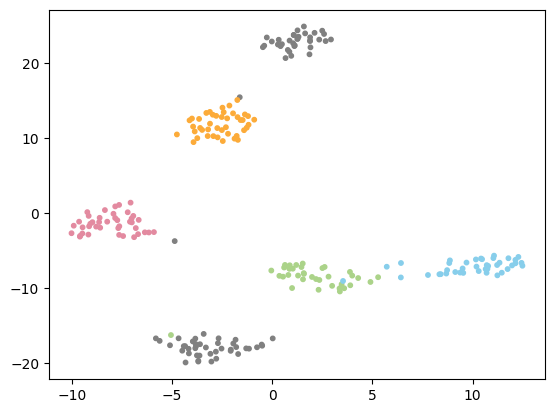

In [23]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [24]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [25]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 6
    for label in range(6):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [26]:
int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [27]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

ID
ID


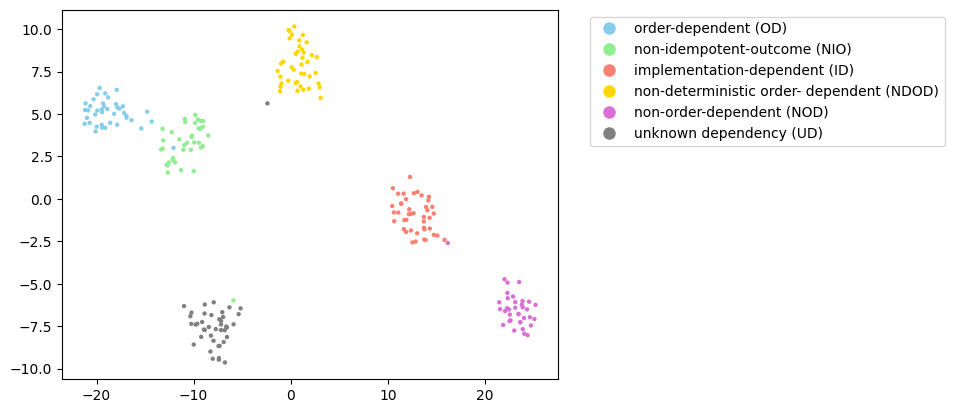

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1, 2, 3, 4, 5]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['order-dependent (OD)', 'non-idempotent-outcome (NIO)', 'implementation-dependent (ID)', 'non-deterministic order- dependent (NDOD)', 'non-order-dependent (NOD)', 'unknown dependency (UD)']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


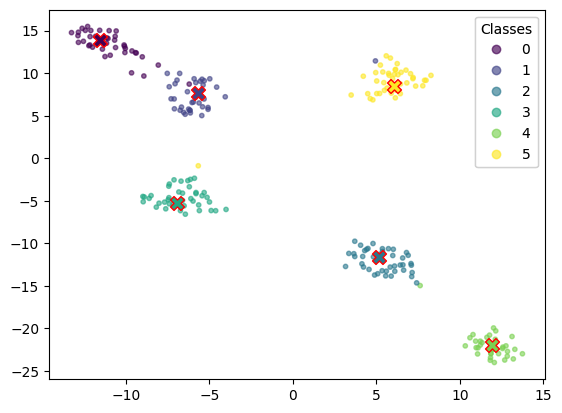

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [30]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [31]:
from sklearn.metrics import f1_score

int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}

label_to_int = {v: k for k, v in int_to_label.items()}  # Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 4 True: 4
2 Predicted: 5 True: 5
3 Predicted: 5 True: 3
4 Predicted: 0 True: 0
5 Predicted: 4 True: 4
6 Predicted: 4 True: 4
7 Predicted: 3 True: 3
8 Predicted: 0 True: 2
9 Predicted: 0 True: 0
10 Predicted: 2 True: 3
11 Predicted: 4 True: 4
12 Predicted: 3 True: 1
13 Predicted: 5 True: 4
14 Predicted: 2 True: 0
15 Predicted: 1 True: 3
16 Predicted: 4 True: 4
17 Predicted: 2 True: 5
18 Predicted: 0 True: 4
19 Predicted: 2 True: 2
20 Predicted: 0 True: 3
21 Predicted: 0 True: 1
22 Predicted: 0 True: 2
23 Predicted: 4 True: 4
24 Predicted: 2 True: 5
25 Predicted: 2 True: 2
26 Predicted: 0 True: 0
27 Predicted: 1 True: 5
28 Predicted: 5 True: 5
29 Predicted: 0 True: 3
30 Predicted: 4 True: 4
31 Predicted: 2 True: 0
32 Predicted: 4 True: 3
33 Predicted: 0 True: 0
34 Predicted: 0 True: 0
35 Predicted: 4 True: 4
36 Predicted: 2 True: 2
37 Predicted: 0 True: 0
38 Predicted: 1 True: 1
39 Predicted: 0 True: 0
40 Predicted: 1 True: 1
41 Predicted: 0 True: 1
42 Predicted: 5 True: 1
4

              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           1       0.57      0.33      0.42        12
           2       0.23      0.43      0.30         7
           3       0.33      0.11      0.17         9
           4       0.77      0.71      0.74        14
           5       0.43      0.38      0.40         8

    accuracy                           0.48        60
   macro avg       0.47      0.46      0.44        60
weighted avg       0.51      0.48      0.47        60


 - Accuracy :  0.48
 - Precision :  0.51
 - Recall :  0.48
 - F1 score :  0.47
 - MCC :  0.39
 - AUC :  0.69


Performances by categories



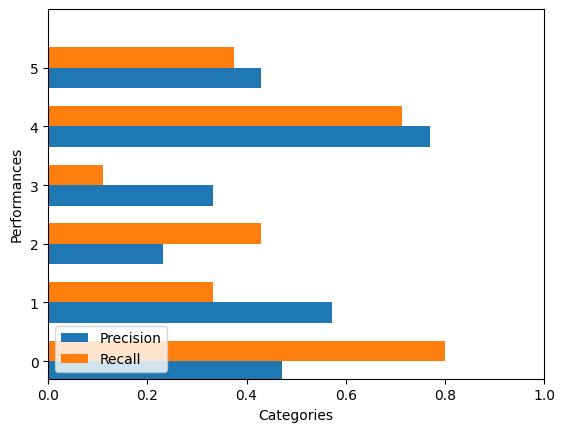



Confusion Matrix 


<AxesSubplot:>

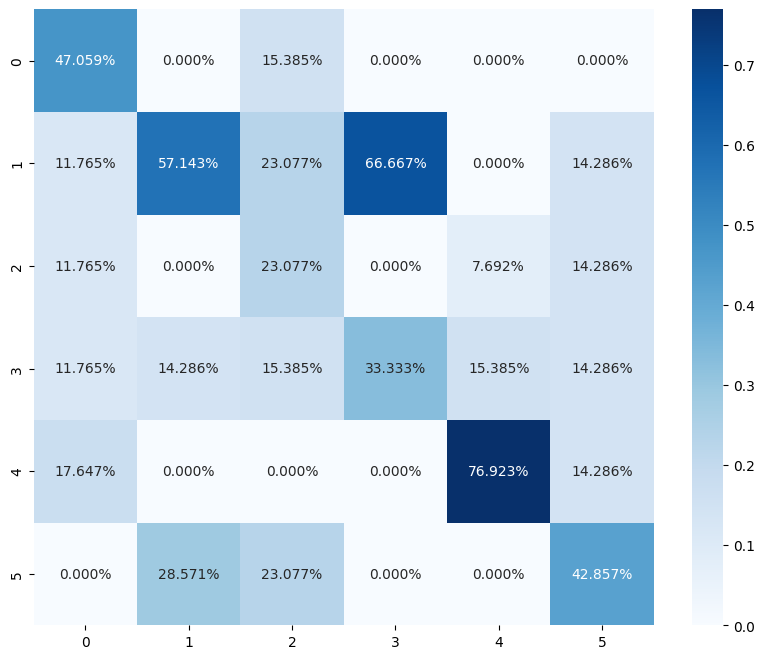

In [32]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


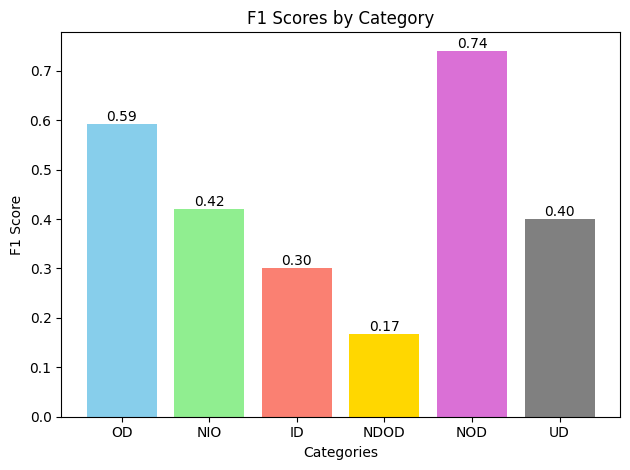

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label={
    0: 'OD',
    1: 'NIO',
    2: 'ID',
    3: 'NDOD',
    4: 'NOD',
    5: 'UD'
}

# Shortened category names
shortened_labels = {
    'OD': 'OD',
    'NIO': 'NIO',
    'ID': 'ID',
    'NDOD': 'NDOD',
    'NOD': 'NOD',
    'UD': 'UD'
}

# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [34]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [35]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [36]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [37]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# def extract_projections(siamese_network, dataloader):
#     projections = []
#     labels = []
#     for batch in dataloader:
#         label = batch["label"]
#         anchor = batch["anchor"]
#         projection = siamese_network(anchor)
        
#         projections.append(projection.cpu().detach().numpy())
#         labels.append(label.numpy())
#     projections = np.vstack(projections)
#     labels = np.hstack(labels)
#     return projections, labels

In [38]:
# projections, labels = extract_projections(siamese_network, train_dataloader)
# val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [39]:
# print(len(projections), len(train_dataloader))

In [40]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(projections, labels)

# # Train SVM Classifier
# svm_classifier = SVC(kernel='linear', random_state=42)
# svm_classifier.fit(projections, labels)

In [41]:
# # Evaluate Random Forest Classifier
# rf_predictions = rf_classifier.predict(val_projections)
# rf_accuracy = accuracy_score(val_labels, rf_predictions)
# rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
# print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# # Evaluate SVM Classifier
# svm_predictions = svm_classifier.predict(val_projections)
# svm_accuracy = accuracy_score(val_labels, svm_predictions)
# svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
# print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")